In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

In [2]:
## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Initialize metrics DataFrame.
metrics = reject[['platform','subject','infreq']]

## Section 1: Define Behavioral Metrics

In [3]:
## Load behavioral data.
data = read_csv(os.path.join('data','data.csv'))

## Restrict participants.
data = data.loc[data.subject.isin(reject.subject)]

#### 1.1 Accuracy

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Merge with metrics.
metrics = metrics.merge(reject[['subject','platform','accuracy']])

#### 1.2 WSLS

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Merge with metrics.
metrics = metrics.merge(reject[['subject','platform','wsls']])

#### 1.3 Perseveration

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define trial number within each block.
data['exposure'] = data.groupby(['subject','block']).trial.transform(lambda x: np.arange(x.size)+1)

## Define perseveration errors.
data['perseveration'] = data.groupby('subject').correct.transform(lambda x: np.roll(x, 15))
data['perseveration'] = (data['perseveration'] == data['choice']).astype(int)
data.loc[data.block==1,'perseveration'] = np.nan

## Compute perseveration errors within participants.
gb = data.query('exposure >= 2 and exposure <= 6').groupby(['subject']).perseveration.mean().reset_index()

## Merge with metrics.
metrics = metrics.merge(gb)

## Section 2: Define Self-Report Metrics

In [71]:
## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(metrics.subject)]

## Define subscales.
subscales = {
    '7u':       ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':       ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':     ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'bisbas_1': ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bisbas_2': ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    'bisbas_3': ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps':    ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
                 'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
                 'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

#### 2.1 Self-Report Sum Scores

In [72]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively compute sum scores.
for k, v in subscales.items():
    
    surveys[k] = surveys[v].sum(axis=1)
    
## Merge with metrics.
metrics = metrics.merge(surveys[['subject','platform'] + list(subscales.keys())])

## Section 3:

100%|██████████| 5000/5000 [01:17<00:00, 64.84it/s]


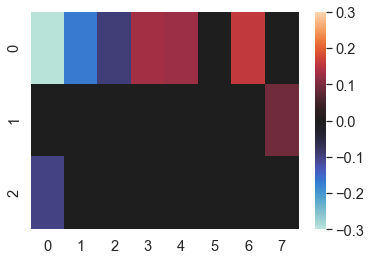

In [105]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of bootstraps.
n_iter = 5000

## Define variables of interest.
index = ['accuracy','wsls','perseveration']
cols  = list(subscales.keys())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## 
copy = metrics.copy()

## Observed.
corr = copy.corr(method='spearman').loc[index,cols].values

## Preallocate space.
null = np.zeros((n_iter,*corr.shape))

## Main loop.
indices = np.arange(copy.shape[0])
for i in tqdm(range(n_iter)):
    
    ## 
    ix = np.random.choice(indices, indices.size, replace=True)
    
    null[i] = copy.iloc[ix].corr(method='spearman').loc[index,cols].values
    
## 
pvals = np.where(np.sign(corr) > 0, null < 0, null > 0).mean(axis=0)

sns.heatmap(np.where(pvals < 0.05, corr, 0), vmin=-0.3, vmax=0.3, center=0)

100%|██████████| 5000/5000 [01:44<00:00, 48.02it/s]


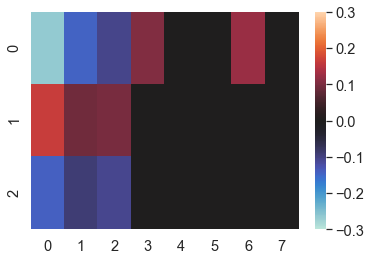

In [116]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of bootstraps.
n_iter = 5000

## Define variables of interest.
index = ['accuracy','wsls','perseveration']
cols  = list(subscales.keys())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## 
copy = metrics.query('accuracy > 0.411').copy()

## Observed.
corr = copy.corr(method='spearman').loc[index,cols].values

## Preallocate space.
null = np.zeros((n_iter,*corr.shape))

## Main loop.
indices = np.arange(copy.shape[0])
for i in tqdm(range(n_iter)):
    
    ## 
    ix = np.random.choice(indices, indices.size, replace=True)
    
    null[i] = copy.iloc[ix].corr(method='spearman').loc[index,cols].values
    
## 
pvals = np.where(np.sign(corr) > 0, null < 0, null > 0).mean(axis=0)

sns.heatmap(np.where(pvals < 0.05, corr, 0), vmin=-0.3, vmax=0.3, center=0)

100%|██████████| 5000/5000 [01:12<00:00, 68.77it/s]


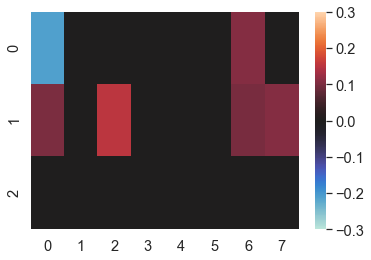

In [127]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of bootstraps.
n_iter = 5000

## Define variables of interest.
index = ['accuracy','wsls','perseveration']
cols  = list(subscales.keys())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## 
copy = metrics.query('infreq==0').copy()

## Observed.
corr = copy.corr(method='spearman').loc[index,cols].values

## Preallocate space.
null = np.zeros((n_iter,*corr.shape))

## Main loop.
indices = np.arange(copy.shape[0])
for i in tqdm(range(n_iter)):
    
    ## 
    ix = np.random.choice(indices, indices.size, replace=True)
    
    null[i] = copy.iloc[ix].corr(method='spearman').loc[index,cols].values
    
## 
pvals = np.where(np.sign(corr) > 0, null < 0, null > 0).mean(axis=0)

sns.heatmap(np.where(pvals < 0.05, corr, 0), vmin=-0.3, vmax=0.3, center=0)

100%|██████████| 5000/5000 [01:14<00:00, 67.03it/s]


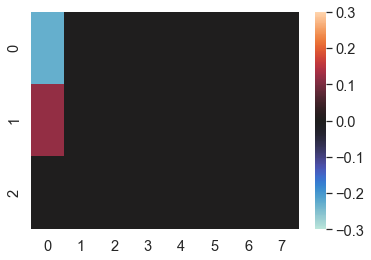

In [126]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of bootstraps.
n_iter = 5000

## Define variables of interest.
index = ['accuracy','wsls','perseveration']
cols  = list(subscales.keys())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## 
copy = metrics.query('infreq==0 and accuracy > 0.411').copy()

## Observed.
corr = copy.corr(method='spearman').loc[index,cols].values

## Preallocate space.
null = np.zeros((n_iter,*corr.shape))

## Main loop.
indices = np.arange(copy.shape[0])
for i in tqdm(range(n_iter)):
    
    ## 
    ix = np.random.choice(indices, indices.size, replace=True)
    
    null[i] = copy.iloc[ix].corr(method='spearman').loc[index,cols].values
    
## 
pvals = np.where(np.sign(corr) > 0, null < 0, null > 0).mean(axis=0)

sns.heatmap(np.where(pvals < 0.05, corr, 0), vmin=-0.3, vmax=0.3, center=0)

In [131]:
from stantools.stats import phi_approx
from scipy.stats import norm

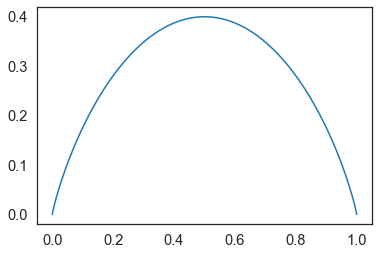

In [135]:
x = np.linspace(-5,5,1001)
y = phi_approx(x)
pdf = norm(0,1).pdf(x)

plt.plot(y,pdf)